In [5]:
import  os
from matplotlib import pyplot as plt
import numpy as np

# 导入MindSpore相关模块，用于深度学习模型的构建和训练
import mindspore as ms
import mindspore.context as context  # 用于设置运行环境
import mindspore.dataset as ds  # 用于数据集操作
import mindspore.dataset.transforms.c_transforms as C  # 用于数据转换操作
import mindspore.dataset.vision.c_transforms as CV  # 用于图像转换操作
from mindspore.nn.metrics import Accuracy  # 用于模型评估指标

# 导入MindSpore的nn模块，用于构建神经网络模型
from mindspore import nn
# 导入MindSpore的Model模块，用于模型的训练和预测
from mindspore.train import Model
# 导入MindSpore的callback模块，用于在模型训练过程中执行特定操作，例如模型保存、损失打印和时间监控
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor

# 设置MindSpore的运行环境，模式为图模式（GRAPH_MODE），设备为CPU
context.set_context(mode=context.GRAPH_MODE, device_target='CPU')


In [6]:
# 设置训练集的路径
DATA_DIR_TRAIN = "./data/MNIST_Data/train"
# 设置测试集的路径
DATA_DIR_TEST = "./data/MNIST_Data/test"
# 使用MindSpore的数据集模块读取训练集
ds_train = ds.MnistDataset(DATA_DIR_TRAIN)
# 使用MindSpore的数据集模块读取测试集
ds_test = ds.MnistDataset(DATA_DIR_TEST)
# 输出训练数据集的大小
print('训练数据集数量：',ds_train.get_dataset_size())
# 输出测试数据集的大小
print('测试数据集数量：',ds_test.get_dataset_size())
# 从训练集中获取一条数据记录
image=ds_train.create_dict_iterator().__next__()
# 输出这条数据记录中的图像数据的形状
print('图像长/宽/通道数：',image['image'].shape)
# 输出这条数据记录中的标签数据
print('一张图像的标签样式：',image['label'])


训练数据集数量： 60000
测试数据集数量： 10000
图像长/宽/通道数： (28, 28, 1)
一张图像的标签样式： 8


In [7]:
# 定义创建数据集的函数，该函数接收是否训练、批量大小、图片大小、归一化系数、偏移量和打乱缓冲区大小作为参数
def create_dataset(training=True, batch_size=128, resize=(28, 28),
                   rescale=1/255, shift=0, buffer_size=64):
    # 创建Mnist数据集，如果training为True，创建的是训练集，否则创建的是测试集
    ds = ms.dataset.MnistDataset(DATA_DIR_TRAIN if training else DATA_DIR_TEST)
    # 定义尺寸缩放的Map操作，将图片大小调整为resize参数指定的大小
    resize_op = CV.Resize(resize)
    # 定义归一化的Map操作，通过rescale和shift参数将图片的像素值转换到0-1之间
    rescale_op = CV.Rescale(rescale, shift)
    # 定义通道变换的Map操作，将图片的通道顺序从高x宽x通道（HWC）变为通道x高x宽（CHW）
    hwc2chw_op = CV.HWC2CHW()
    # 对数据集进行Map操作，对图片进行尺寸缩放、归一化和通道变换操作
    ds = ds.map(input_columns="image", operations=[rescale_op, resize_op, hwc2chw_op])
    # 对数据集的标签进行Map操作，将标签的数据类型转换为int32
    ds = ds.map(input_columns="label", operations=C.TypeCast(ms.int32))
    # 对数据集进行打乱操作，buffer_size参数表示打乱缓冲区的大小
    ds = ds.shuffle(buffer_size=buffer_size)
    # 对数据集进行批量化操作，每个批次包含batch_size数量的样本，drop_remainder参数为True表示如果最后一个批次的样本数量不足batch_size，则丢弃该批次
    ds = ds.batch(batch_size, drop_remainder=True)
    # 返回创建好的数据集
    return ds

[WARNING] ME(47584:50460,MainProcess):2023-07-14-15:13:21.498.962 [mindspore\dataset\core\validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(47584:50460,MainProcess):2023-07-14-15:13:21.500.458 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(47584:50460,MainProcess):2023-07-14-15:13:21.501.596 [mindspore\dataset\core\validator_helpers.py:806] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(47584:50460,MainProcess):2023-07-14-15:13:21.503.152 [mindspore\dataset\core\validator_helpers.py:806] 'Typ

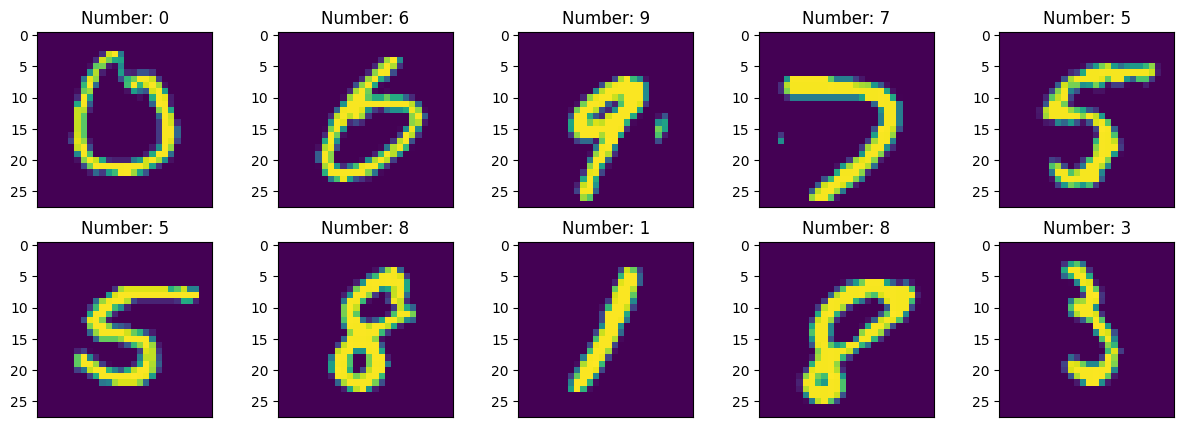

In [11]:
# 调用之前定义的create_dataset函数创建测试集
ds = create_dataset(training=False)
# 从数据集中取出一批数据，create_dict_iterator()方法用于创建一个字典迭代器用于遍历数据集，__next__()方法用于获取下一个批次的数据
data = ds.create_dict_iterator().__next__()
# 从获取的数据中取出图像，并将图像的数据类型转换为numpy.ndarray
images = data['image'].asnumpy()
# 从获取的数据中取出标签，并将标签的数据类型转换为numpy.ndarray
labels = data['label'].asnumpy()
# 创建一个新的图形窗口，大小为15x5
plt.figure(figsize=(15,5))
# 用一个循环在图形窗口上绘制10个子图
for i in range(1,11):
    # 在图形窗口的第i个位置创建一个子图
    plt.subplot(2, 5, i)
    """np.squeeze 是一个 NumPy 的函数，它的主要作用是从形状中删除单维度条目，即删除维数为1的那些维度。
例如，如果你有一个数组形状是 (1, 3, 1, 2)，如果你应用 np.squeeze 函数，它将变为 (3, 2)。这个函数会删除所有维度为1的维度。
在处理图像数据的时候，有时候我们可能会碰到一些包含多余维度的情况，比如一个灰度图像可能会有三个维度，形如 (28, 28, 1)，
但实际上，我们知道灰度图像只需要两个维度，于是就可以利用 np.squeeze 来去除那个维度为1的维度，使图像数据变为 (28, 28)。
"""
    # 在创建的子图上绘制图像，使用np.squeeze方法去掉图像数据的单维度条目
    plt.imshow(np.squeeze(images[i]))
    # 为子图添加标题，标题内容为对应的数字标签
    plt.title('Number: %s' % labels[i])
    # 隐藏子图的x轴刻度
    plt.xticks([])
# 显示图形窗口
plt.show()


In [9]:
# 定义一个前向神经网络类，继承自MindSpore的nn.Cell
class ForwardNN(nn.Cell):      
    # 初始化函数
    def __init__(self):
        # 调用父类的初始化函数
        super(ForwardNN, self).__init__()
        # 定义一个Flatten层，将输入数据拉平，例如将28*28的二维图像数据转化为一维的784长度的数据
        self.flatten = nn.Flatten()
        # 定义第一个全连接层，输入节点数为784，输出节点数为512，激活函数为ReLU
        self.fc1 = nn.Dense(784, 512, activation='relu')  
        # 定义第二个全连接层，输入节点数为512，输出节点数为128，激活函数为ReLU
        self.fc2 = nn.Dense(512, 128, activation='relu')
        # 定义第三个全连接层，输入节点数为128，输出节点数为10，激活函数为None（无激活函数）
        self.fc3 = nn.Dense(128, 10, activation=None)
       
    
    # 定义构造函数，用于构造计算图
    def construct(self, input_x):
        # 首先，将输入数据拉平
        output = self.flatten(input_x)
        # 然后，将拉平后的数据输入到第一个全连接层
        output = self.fc1(output)
        # 将第一个全连接层的输出作为输入，输入到第二个全连接层
        output = self.fc2(output) 
        # 将第二个全连接层的输出作为输入，输入到第三个全连接层
        output = self.fc3(output)
        # 返回最后的输出
        return output  

In [10]:
# 定义学习率为0.001，这是优化器在更新模型参数时使用的步长
lr = 0.001
# 定义训练的轮数为5，这表示整个数据集将被遍历5次
num_epoch = 5
# 定义优化器中的动量因子为0.9，这是用于加速梯度向量在正确方向上下降，并抑制震荡的参数
momentum = 0.9

# 创建网络实例
net = ForwardNN()
# 创建损失函数实例，这里使用的是softmax交叉熵损失函数，其中sparse参数为True表示标签为整数，reduction参数为'mean'表示对每个小批量数据的损失进行平均
loss = nn.loss.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
# 定义评估指标，这里使用的是精度指标
metrics={"Accuracy": Accuracy()}
# 创建优化器实例，这里使用的是Adam优化器，其中第一个参数是需要优化的参数（这里是网络的可训练参数），第二个参数是学习率
opt = nn.Adam(net.trainable_params(), lr) 

In [13]:
size = ds_train.get_dataset_size()
print('数据集的大小：', size)

数据集的大小： 60000


In [14]:
# 创建Model实例，将网络结构、损失函数、优化器以及评估指标作为输入参数
model = Model(net, loss, opt, metrics)

# 定义模型保存的配置，其中每1875步保存一次模型，且最多保存10个模型
config_ck = CheckpointConfig(save_checkpoint_steps=1875, keep_checkpoint_max=10)

# 创建ModelCheckpoint实例，其中prefix参数表示模型保存的前缀，directory参数表示模型保存的目录，config参数表示模型保存的配置
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_net",directory = "./ckpt" ,config=config_ck)

# 创建数据集，分别是用于验证的数据集ds_eval和用于训练的数据集ds_train
ds_eval = create_dataset(False, batch_size=32)
ds_train = create_dataset(batch_size=32)

# 创建LossMonitor实例，每1875次迭代打印一次当前的损失值
loss_cb = LossMonitor(per_print_times=1875)

# 创建TimeMonitor实例，用于记录训练过程中的时间，其中data_size参数表示每个epoch中批次的数量
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())

# 输出开始训练的信息
print("============== Starting Training ==============")
# 使用Model实例的train方法开始训练模型，其中num_epoch参数表示训练的轮数，ds_train参数表示用于训练的数据集，callbacks参数表示回调函数的列表，dataset_sink_mode参数表示是否开启数据下沉模式，False表示关闭数据下沉模式
model.train(num_epoch, ds_train,callbacks=[ckpoint_cb,loss_cb,time_cb ],dataset_sink_mode=False)


[WARNING] ME(47584:50460,MainProcess):2023-07-14-15:35:54.753.219 [mindspore\dataset\core\validator_helpers.py:806] 'Resize' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Resize' from mindspore.dataset.vision instead.
[WARNING] ME(47584:50460,MainProcess):2023-07-14-15:35:54.755.344 [mindspore\dataset\core\validator_helpers.py:806] 'Rescale' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'Rescale' from mindspore.dataset.vision instead.
[WARNING] ME(47584:50460,MainProcess):2023-07-14-15:35:54.756.329 [mindspore\dataset\core\validator_helpers.py:806] 'HWC2CHW' from mindspore.dataset.vision.c_transforms is deprecated from version 1.8 and will be removed in a future version. Use 'HWC2CHW' from mindspore.dataset.vision instead.
[WARNING] ME(47584:50460,MainProcess):2023-07-14-15:35:54.757.330 [mindspore\dataset\core\validator_helpers.py:806] 'Typ

============== Starting Training ==============
epoch: 1 step: 1875, loss is 0.01117376983165741
Train epoch time: 10644.165 ms, per step time: 5.677 ms
epoch: 2 step: 1875, loss is 0.005071254912763834
Train epoch time: 13347.215 ms, per step time: 7.119 ms
epoch: 3 step: 1875, loss is 0.02302972413599491
Train epoch time: 13813.926 ms, per step time: 7.367 ms
epoch: 4 step: 1875, loss is 0.09709800779819489
Train epoch time: 14053.375 ms, per step time: 7.495 ms
epoch: 5 step: 1875, loss is 0.06500797718763351
Train epoch time: 14954.343 ms, per step time: 7.976 ms


In [15]:
#使用测试集评估模型，打印总体准确率
metrics=model.eval(ds_eval)
print(metrics)

{'Accuracy': 0.9793669871794872}
